Library

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import math
import time

Load Grouped Dataframes from Mastra

In [2]:
grouped_dataframes = pd.read_pickle('grouped_dataframes.pkl')

In [3]:
for key in grouped_dataframes.keys():
    grouped_dataframes[key] = grouped_dataframes[key][~grouped_dataframes[key].index.duplicated(keep='first')]

In [4]:
import pandas as pd
import numpy as np
import time

# Define the date range
date_range = pd.date_range(start='2023-01-01', end='2024-08-31', freq='D')

# Define the time range with 15-minute intervals
time_range = pd.date_range(start='00:00', end='23:45', freq='15min').time

# Create a MultiIndex with all combinations of dates and times
multi_index = pd.MultiIndex.from_product([date_range, time_range], names=['Dato', 'time_start'])

# Create the DataFrame
empty_df = pd.DataFrame(index=multi_index, columns=['Vej-Id', 'Xkoordinat', 'Ykoordinat', 'traffic_flow'])

# Reset the index to have 'datetime' as a column
empty_df = empty_df.reset_index()

# Format 'Dato' as mm.dd.yyyy
empty_df['Dato'] = empty_df['Dato'].dt.strftime('%d.%m.%Y')

# Combine 'Dato' and 'time_start' into a single datetime column (ensure correct formatting)
empty_df['datetime'] = pd.to_datetime(empty_df['Dato'] + ' ' + empty_df['time_start'].astype(str), format='%d.%m.%Y %H:%M:%S')

# Convert datetime to UNIX timestamp
empty_df['datetime'] = empty_df['datetime'].apply(lambda dt: int(time.mktime(dt.timetuple())))

# Set 'datetime' as the index
empty_df = empty_df.set_index('datetime')

# Ensure 'time_start' contains only hour and minutes as strings
empty_df['time_start'] = empty_df.index.map(lambda ts: pd.to_datetime(ts, unit='s').strftime('%H:%M'))

# Fill other columns with placeholder data
empty_df['Vej-Id'] = np.nan  # Placeholder for Vej-Id
empty_df['Dato'] = empty_df.index.map(lambda ts: pd.to_datetime(ts, unit='s').strftime('%d.%m.%Y'))  # Re-format Dato column

# Set NaN for other columns
empty_df['Xkoordinat'] = np.nan          # Set NaN for Xkoordinat
empty_df['Ykoordinat'] = np.nan          # Set NaN for Ykoordinat
empty_df['traffic_flow'] = np.nan        # Set NaN for traffic_flow

# Reorder columns
empty_df = empty_df[['Vej-Id', 'Dato', 'Xkoordinat', 'Ykoordinat', 'traffic_flow', 'time_start']]

# Remove the first 4 rows and adjust index
empty_df = empty_df.iloc[4:]
empty_df.index = empty_df.index - 3600  # Subtract 3600 seconds (1 hour) from each index value

# Define the additional time range for 31.08.2024
additional_time_range = pd.date_range(start='2024-08-31 22:00', end='2024-08-31 23:45', freq='15min')

# Create a DataFrame for the new rows
additional_df = pd.DataFrame({
    'datetime': additional_time_range.map(lambda dt: int(time.mktime(dt.timetuple()))),  # Convert to UNIX timestamp
    'Vej-Id': np.nan,
    'Dato': additional_time_range.strftime('%d.%m.%Y'),
    'Xkoordinat': np.nan,
    'Ykoordinat': np.nan,
    'traffic_flow': np.nan,
    'time_start': additional_time_range.strftime('%H:%M'),
})

# Set 'datetime' as the index
additional_df = additional_df.set_index('datetime')

# Append the new rows to the original DataFrame
empty_df = pd.concat([empty_df, additional_df])

# Display the last few rows to verify
empty_df.shape

for key in grouped_dataframes.keys():
    grouped_dataframes[key] = empty_df.combine_first(grouped_dataframes[key])

In [6]:
for key, df in grouped_dataframes.items():
    print("Dupliacted: ", df.index.duplicated().any(), "Length: ", len(df.index), df.index[0], df.index[-1], "notna: ", df['traffic_flow'].notna().sum(), "Toal: ", len(df.index))


Dupliacted:  True Length:  58472 1672527600 1725140700 notna:  33533 Toal:  58472
Dupliacted:  True Length:  58472 1672527600 1725140700 notna:  33533 Toal:  58472
Dupliacted:  True Length:  58472 1672527600 1725140700 notna:  33533 Toal:  58472
Dupliacted:  True Length:  58472 1672527600 1725140700 notna:  33533 Toal:  58472
Dupliacted:  True Length:  58472 1672527600 1725140700 notna:  33533 Toal:  58472
Dupliacted:  True Length:  58472 1672527600 1725140700 notna:  33533 Toal:  58472
Dupliacted:  True Length:  58472 1672527600 1725140700 notna:  33533 Toal:  58472
Dupliacted:  True Length:  58472 1672527600 1725140700 notna:  56641 Toal:  58472
Dupliacted:  True Length:  58472 1672527600 1725140700 notna:  56641 Toal:  58472
Dupliacted:  True Length:  58472 1672527600 1725140700 notna:  56641 Toal:  58472
Dupliacted:  True Length:  58472 1672527600 1725140700 notna:  56641 Toal:  58472
Dupliacted:  True Length:  58472 1672527600 1725140700 notna:  56641 Toal:  58472
Dupliacted:  Tru

In [7]:
def adjust_traffic_flow(df, column_name, multiplier=2):
    """
    Adjusts the traffic flow value of 1.0 in a DataFrame to 1000 if it is between
    two values that are significantly higher (default: multiple of 2).

    Args:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The name of the traffic flow column.
        multiplier (float): The factor that determines "significantly higher".

    Returns:
        pd.DataFrame: Modified DataFrame with adjusted traffic flow values.
    """
    traffic_flow = df[column_name].values
    for i in range(1, len(traffic_flow) - 1):
        # Check if the current value is 1.0 and it's between two values that are higher
        if (traffic_flow[i] == 1.0 and 
            traffic_flow[i - 1] > 900 and 
            traffic_flow[i + 1] > 900):
            traffic_flow[i] = 1000
    
    # Update the DataFrame column
    df[column_name] = traffic_flow
    return df

grouped_dataframes = {key: adjust_traffic_flow(df, 'traffic_flow') for key, df in grouped_dataframes.items()}

In [8]:
columns_to_keep = ['Vej-Id', 'Dato', 'Xkoordinat', 'Ykoordinat', 'traffic_flow', 'time_start']
cleaned_dataframes = {}

for key in grouped_dataframes.keys():
    grouped_dataframes[key] = grouped_dataframes[key][columns_to_keep]
    grouped_dataframes[key]['traffic_flow'] = grouped_dataframes[key]['traffic_flow'].apply(lambda x: x * 10**3 if not pd.isna(x) and x != int(x) else x)

    # # check for index duplicates
    # if grouped_dataframes[key].index.duplicated().any():
    #     # drop duplicates
    #     cleaned_dataframes[key] = grouped_dataframes[key].reset_index(drop=True)


C:\Users\gonde\AppData\Local\Temp\ipykernel_14984\3103714261.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_dataframes[key]['traffic_flow'] = grouped_dataframes[key]['traffic_flow'].apply(lambda x: x * 10**3 if not pd.isna(x) and x != int(x) else x)


Only use Total Dataframes

In [9]:
# Filtered and unique dataframes processing
filtered_dataframes = {}
unique_dataframes = {}
cords = []
names = list(grouped_dataframes.keys())
k = 0

for name in names:
    single_name = name[0]
    
    # Check if the name ends with "T"
    if single_name[-1] in ["T"]:
        # Add to filtered dataframes
        filtered_dataframes[name] = grouped_dataframes[name]
        
        # Extract coordinates
        x, y = grouped_dataframes[name]['Xkoordinat'].iloc[0], grouped_dataframes[name]['Ykoordinat'].iloc[0]
        
        # Check for uniqueness and add to unique_dataframes
        if (x, y) not in cords:
            unique_dataframes[name] = grouped_dataframes[name]
            cords.append((x, y))
            k += 1
    
print("Unique Dataframes", k)

Unique Dataframes 136


Look at NA Values

In [10]:
for key in filtered_dataframes.keys():
    df = filtered_dataframes[key]
    print(key, "NA", df['traffic_flow'].isna().sum(), "\n", "NotNA", df['traffic_flow'].notna().sum())

('0 450-0 7/ 300 T', 552601.0, 6329842.0) NA 24939 
 NotNA 33533
('0 450-0 9/1675 T', 549360.0, 6330576.0) NA 1831 
 NotNA 56641
('0 70-0 277/ 100 T', 552269.0, 6311346.0) NA 9656 
 NotNA 48816
('0 70-0 278/ 201 T', 552730.0, 6312348.0) NA 9421 
 NotNA 49051
('0 70-0 279/ 100 T', 553084.0, 6313171.0) NA 28101 
 NotNA 30371
('0 70-0 284/ 400 T', 555132.0, 6317792.0) NA 2017 
 NotNA 56455
('0 70-0 284/ 950 T', 555308.0, 6318304.0) NA 2017 
 NotNA 56455
('0 70-0 285/ 700 T', 555789.0, 6318873.0) NA 29885 
 NotNA 28587
('0 70-0 286/ 100 T', 556145.0, 6319061.0) NA 7520 
 NotNA 50952
('0 70-0 288/ 424 T', 558245.0, 6319907.0) NA 3376 
 NotNA 55096
('0 70-0 289/ 350 T', 558753.0, 6320685.0) NA 20176 
 NotNA 38296
('0 70-0 289/ 950 T', 559007.0, 6321227.0) NA 3917 
 NotNA 54555
('0 70-0 290/ 951 T', 559026.0, 6322227.0) NA 11128 
 NotNA 47344
('0 70-0 291/ 452 T', 558976.0, 6322726.0) NA 3470 
 NotNA 55002
('0 70-0 291/ 625 T', 558956.0, 6322898.0) NA 2236 
 NotNA 56236
('0 70-0 292/ 0 T', 55

Find Longest period and Interpolate NA Values

In [30]:
import pandas as pd

def find_and_apply_longest_period(filtered_dataframes, threshold=5):
    """
    Loops over all dataframes in filtered_dataframes, finds the longest period 
    without exceeding the threshold of consecutive NaN values, and filters 
    the dataframe to include only that period.

    Parameters:
    - filtered_dataframes (dict): A dictionary of dataframes to process.
    - threshold (int): Maximum allowed consecutive NaN values.

    Returns:
    - dict: Updated filtered_dataframes with filtered dataframes.
    """
    def find_longest_valid_period(series, threshold):
        """
        Finds the longest valid period in the series, allowing up to `threshold` NaN values consecutively.
        """
        mask = series.notna()
        count = 0
        start = end = 0
        max_start = max_end = 0
        nans = 0

        for i in range(len(mask)):
            if mask.iloc[i]:
                count += 1
                nans = 0
            else:
                nans += 1
                if nans > threshold:
                    count = 0
                    nans = 0
                    start = i + 1
            if count > (max_end - max_start):
                max_start, max_end = start, i + 1
        return max_start, max_end

    for name, df in filtered_dataframes.items():
        # Assuming the column to check for NaN values is named 'Value'
        if 'traffic_flow' in df.columns:
            start_idx, end_idx = find_longest_valid_period(df['traffic_flow'], threshold)
            filtered_dataframes[name] = df.iloc[start_idx:end_idx]

    return filtered_dataframes

filtered_dataframes_period = find_and_apply_longest_period(filtered_dataframes.copy(), threshold=5)

In [31]:
for name, df in filtered_dataframes_period.items():
    # Interpolate NaN values in all columns with numeric data
    filtered_dataframes_period[name]['traffic_flow'] = df['traffic_flow'].interpolate(method='linear', limit_direction='both')


C:\Users\gonde\AppData\Local\Temp\ipykernel_14984\2306075207.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dataframes_period[name]['traffic_flow'] = df['traffic_flow'].interpolate(method='linear', limit_direction='both')


Verify amount of Na Values

In [32]:
# longest consecutive streak of NA in filtered_dataframes_period[name]['traffic_flow']
for name in filtered_dataframes_period:
    print(name, filtered_dataframes_period[name]['traffic_flow'].isna().astype(int).groupby(filtered_dataframes_period[name]['traffic_flow'].notna().astype(int).cumsum()).cumsum().max(), len(filtered_dataframes_period[name]['traffic_flow']))

('0 450-0 7/ 300 T', 552601.0, 6329842.0) 0 34273
('0 450-0 9/1675 T', 549360.0, 6330576.0) 0 57319
('0 70-0 277/ 100 T', 552269.0, 6311346.0) 0 4270
('0 70-0 278/ 201 T', 552730.0, 6312348.0) 0 4852
('0 70-0 279/ 100 T', 553084.0, 6313171.0) 0 4270
('0 70-0 284/ 400 T', 555132.0, 6317792.0) 0 34445
('0 70-0 284/ 950 T', 555308.0, 6318304.0) 0 34445
('0 70-0 285/ 700 T', 555789.0, 6318873.0) 0 15982
('0 70-0 286/ 100 T', 556145.0, 6319061.0) 0 15982
('0 70-0 288/ 424 T', 558245.0, 6319907.0) 0 13843
('0 70-0 289/ 350 T', 558753.0, 6320685.0) 0 10647
('0 70-0 289/ 950 T', 559007.0, 6321227.0) 0 8588
('0 70-0 290/ 951 T', 559026.0, 6322227.0) 0 8937
('0 70-0 291/ 452 T', 558976.0, 6322726.0) 0 15150
('0 70-0 291/ 625 T', 558956.0, 6322898.0) 0 13239
('0 70-0 292/ 0 T', 558880.0, 6323318.0) 0 13239
('0 70-0 293/ 370 T', 557951.0, 6324241.0) 0 4410
('0 70-0 293/ 400 T', 557929.0, 6324261.0) 0 14667
('0 70-0 293/ 640 T', 557757.0, 6324428.0) 0 5272
('0 70-0 293/ 960 T', 557594.0, 6324700.0)

Find the dataframes which have the most data over the longest time

In [33]:
def remove_extreme_dataframes(one_week_dfs, n, m):
    # Sort dataframes by their starting index value
    sorted_by_start = sorted(one_week_dfs.items(), key=lambda item: item[1].index[0])
    
    # Sort dataframes by their ending index value
    sorted_by_end = sorted(one_week_dfs.items(), key=lambda item: item[1].index[-1])
    
    # Remove n dataframes with the highest starting index value
    to_remove_start = sorted_by_start[-n:]
    
    # Remove m dataframes with the lowest ending index value
    to_remove_end = sorted_by_end[:m]
    
    # Create a set of keys to remove
    keys_to_remove = set(key for key, _ in to_remove_start + to_remove_end)
    
    # Remove the dataframes from one_week_dfs
    one_week_dfs = {key: df for key, df in one_week_dfs.items() if key not in keys_to_remove}
    
    return one_week_dfs

highest_duration = 0
count_removing = 200

for n in range(0, 80):
    for m in range(0, 80):
        temp_one_week_dfs = remove_extreme_dataframes(filtered_dataframes_period, n, m)
        
        if temp_one_week_dfs:  # Check if temp_one_week_dfs is not empty
            highest_starting_index = max(df.index[0] for df in temp_one_week_dfs.values())
            lowest_ending_index = min(df.index[-1] for df in temp_one_week_dfs.values())
            duration_days = ((lowest_ending_index - highest_starting_index) / 3600) / 24
            if duration_days >= 0 and duration_days > highest_duration:
                print(f"n = {n}, m = {m}")
                print("Number of dataframes after removal:", len(temp_one_week_dfs))
                print("Highest starting index value:", highest_starting_index)
                print("Lowest ending index value:", lowest_ending_index)
                print("Duration in days:", duration_days)
                if duration_days > highest_duration and count_removing > n+m:	
                    highest_duration = duration_days
                    count_removing = n + m
                    best_start = highest_starting_index
                    best_end = lowest_ending_index
                    best_n = n
                    best_m = m


print("Best start:", best_start)
print("Best end:", best_end)
print("Best n:", best_n)
print("Best m:", best_m)
print("Highest duration in days:", highest_duration)


n = 18, m = 67
Number of dataframes after removal: 52
Highest starting index value: 1703285100
Lowest ending index value: 1703476800
Duration in days: 2.21875
n = 18, m = 70
Number of dataframes after removal: 49
Highest starting index value: 1703285100
Lowest ending index value: 1703523600
Duration in days: 2.7604166666666665
n = 18, m = 71
Number of dataframes after removal: 48
Highest starting index value: 1703285100
Lowest ending index value: 1703523600
Duration in days: 2.7604166666666665
n = 18, m = 72
Number of dataframes after removal: 47
Highest starting index value: 1703285100
Lowest ending index value: 1703523600
Duration in days: 2.7604166666666665
n = 18, m = 73
Number of dataframes after removal: 46
Highest starting index value: 1703285100
Lowest ending index value: 1703523600
Duration in days: 2.7604166666666665
n = 18, m = 74
Number of dataframes after removal: 45
Highest starting index value: 1703285100
Lowest ending index value: 1703523600
Duration in days: 2.76041666

Drop Duplicates in index and apply the Range

In [34]:
n = 79  # Number of dataframes to remove with the highest starting index value
m = 62  # Number of dataframes to remove with the lowest ending index value
final_dataframes = remove_extreme_dataframes(filtered_dataframes_period, n, m)

In [35]:
start = 1672527600# - 3588300
end = 1703530800

final_dataframes = {}

for name, df in filtered_dataframes_period.items():
    # Ensure the index is unique and monotonic
    if not df.index.is_unique:
        print(f"Duplicate indices found in {name}. Dropping duplicates.")
        # print ducplicates
        df = df[~df.index.duplicated(keep='first')]

    if not df.index.is_monotonic_increasing:
        print(f"Index of {name} is not sorted. Sorting the index.")
        df = df.sort_index()

    if start in df.index and end in df.index:
        final_dataframes[name] = df.loc[start:end]
    # elif start > df.index[0] and end < df.index[-1]:
    #     try:
    #         final_dataframes[name] = df.loc[start:end]
    #     except KeyError:
    #         print("Trying something else")
    #         # Find the nearest index to start and end
    #         start_index = df.index.get_indexer([start], method='nearest')[0]
    #         end_index = df.index.get_indexer([end], method='nearest')[0]
    #         final_dataframes[name] = df.iloc[start_index:end_index+1]
    else:
        print(f"Data range does not fit for {name}. Skipping. Start: {start-df.index[0]}, End: {df.index[-1]-end}")
print("Final Dataframes", len(final_dataframes))


Duplicate indices found in ('0 450-0 7/ 300 T', 552601.0, 6329842.0). Dropping duplicates.
Data range does not fit for ('0 450-0 7/ 300 T', 552601.0, 6329842.0). Skipping. Start: -378000, End: 216000
Duplicate indices found in ('0 450-0 9/1675 T', 549360.0, 6330576.0). Dropping duplicates.
Duplicate indices found in ('0 70-0 277/ 100 T', 552269.0, 6311346.0). Dropping duplicates.
Data range does not fit for ('0 70-0 277/ 100 T', 552269.0, 6311346.0). Skipping. Start: -10368900, End: -16792200
Duplicate indices found in ('0 70-0 278/ 201 T', 552730.0, 6312348.0). Dropping duplicates.
Data range does not fit for ('0 70-0 278/ 201 T', 552730.0, 6312348.0). Skipping. Start: -35422200, End: 8781300
Duplicate indices found in ('0 70-0 279/ 100 T', 553084.0, 6313171.0). Dropping duplicates.
Data range does not fit for ('0 70-0 279/ 100 T', 553084.0, 6313171.0). Skipping. Start: -10368900, End: -16792200
Duplicate indices found in ('0 70-0 284/ 400 T', 555132.0, 6317792.0). Dropping duplicates

In [36]:
# Gather all start and end index values for analysis
start_values = []
end_values = []

for name, df in final_dataframes.items():
    start_values.append(df.index[0])
    end_values.append(df.index[-1])

start_values = pd.Series(start_values)
end_values = pd.Series(end_values)

# Determine the most common start and end indices
common_start = start_values.value_counts().idxmax()
common_end = end_values.value_counts().idxmax()

# Apply the common range to all DataFrames
updated_final_dataframes = {}
for name, df in final_dataframes.items():
    # Check if the common_start and common_end exist in the DataFrame
    if common_start in df.index and common_end in df.index:
        updated_final_dataframes[name] = df.loc[common_start:common_end].copy()
    else:
        print(f"Skipping {name} - range {common_start} to {common_end} not found. Dataframe start: {df.index[0]}, end: {df.index[-1]} Diff start: {common_start - df.index[0]}, end: {df.index[-1] - common_end}")

# Replace the final_dataframes with updated ones
final_dataframes = updated_final_dataframes

# Verify results
print(f"Updated DataFrames: {len(final_dataframes)}")
for name, df in final_dataframes.items():
    print(f"{name}: Start {df.index[0]}, End {df.index[-1]}, Length {len(df)}")


Updated DataFrames: 26
('0 450-0 9/1675 T', 549360.0, 6330576.0): Start 1672527600, End 1703530800, Length 34449
('0 70-3 284/ 780 T', 555292.0, 6318128.0): Start 1672527600, End 1703530800, Length 34449
('0 70-4 291/ 625 T', 558928.0, 6322894.0): Start 1672527600, End 1703530800, Length 34449
('0 70-5 291/ 625 T', 558981.0, 6322888.0): Start 1672527600, End 1703530800, Length 34449
('0 70-6 285/ 65 T', 555341.0, 6318418.0): Start 1672527600, End 1703530800, Length 34449
('0 77-1 294/ 200 T', 557437.0, 6324871.0): Start 1672527600, End 1703530800, Length 34449
('0 77-2 294/ 200 T', 557426.0, 6324854.0): Start 1672527600, End 1703530800, Length 34449
('0 80-3 296/ 950 T', 558870.0, 6327287.0): Start 1672527600, End 1703530800, Length 34449
('0 80-3 303/ 60 T', 563949.0, 6330413.0): Start 1672527600, End 1703530800, Length 34449
('0 80-4 303/ 405 T', 564139.0, 6330707.0): Start 1672527600, End 1703530800, Length 34449
('0 80-5 303/ 285 T', 564096.0, 6330582.0): Start 1672527600, End 1703

____________________________________________________________________

Create a Graph from Final Dataframes

In [37]:
def clean_graph(graph):
    # Remove self-loops
    graph = graph.copy()  # Avoid modifying the
    self_loops = list(nx.selfloop_edges(graph))
    graph.remove_edges_from(self_loops)
    
    # Remove duplicate edges (not necessary for undirected graphs in NetworkX)
    # Here just in case your graph is directed or you need further verification
    edges_to_remove = []
    for u, v, data in graph.edges(data=True):
        if graph.number_of_edges(u, v) > 1:  # More than one edge exists
            edges_to_remove.append((u, v))
    
    graph.remove_edges_from(edges_to_remove)
    largest_component = max(nx.connected_components(graph), key=len)
    graph = graph.subgraph(largest_component)

    print(f"Removed {len(self_loops)} self-loops and {len(edges_to_remove)} duplicate edges. Choose the Largest Component: {len(largest_component)} nodes.")
    # extract largest component

    return graph


def create_correlation_graph(df_dict, threshold=0.5, weighted=False, degree=2):
    """
    Create a correlation graph with a maximum degree constraint.
    """
    correlation_graph = nx.Graph()
    correlations_dict = {}

    # Add nodes to the graph
    for key, df in df_dict.items():
        correlation_graph.add_node(
            key, 
            x=df['Xkoordinat'].iloc[0], 
            y=df['Ykoordinat'].iloc[0], 
            traffic_flow=df['traffic_flow'].values
        )

    # Calculate correlations and store in a dictionary
    for key1, df1 in df_dict.items():
        for key2, df2 in df_dict.items():
            if key1 == key2:
                continue
            correlation = np.corrcoef(df1['traffic_flow'], df2['traffic_flow'])[0, 1]
            correlations_dict[key1, key2] = correlation

    # Add edges based on correlation, enforcing degree constraint
    for key1 in df_dict.keys():
        # Sort potential connections by correlation (highest first)
        potential_edges = [
            (key2, correlations_dict[key1, key2])
            for key2 in df_dict.keys() if key1 != key2 and (key1, key2) in correlations_dict
        ]
        potential_edges = sorted(potential_edges, key=lambda x: -x[1])  # Sort by descending correlation
        
        for key2, corr in potential_edges:
            if correlation_graph.degree[key1] < degree and correlation_graph.degree[key2] < degree:
                if corr > threshold:
                    if weighted:
                        correlation_graph.add_edge(key1, key2, weight=corr)
                    else:
                        correlation_graph.add_edge(key1, key2)

    # Clean graph
    correlation_graph = clean_graph(correlation_graph)
    return correlation_graph, correlations_dict


def create_distance_graph(df_dict, weighted=False, degree=4):
    """
    Create a distance graph with a maximum degree constraint.
    """
    distance_graph = nx.Graph()
    distance_dict = {}

    # Add nodes to the graph
    for key, df in df_dict.items():
        distance_graph.add_node(
            key, 
            x=df['Xkoordinat'].iloc[0], 
            y=df['Ykoordinat'].iloc[0], 
            traffic_flow=df['traffic_flow'].values
        )

    # Calculate distances and store in a dictionary
    for key1, df1 in df_dict.items():
        for key2, df2 in df_dict.items():
            if key1 == key2:
                continue
            idx = df1['traffic_flow'].first_valid_index()
            distance = math.sqrt(
                (df1['Xkoordinat'][idx] - df2['Xkoordinat'][idx])**2 +
                (df1['Ykoordinat'][idx] - df2['Ykoordinat'][idx])**2
            )
            distance_dict[key1, key2] = distance

    # Add edges based on distance, enforcing degree constraint
    threshold = sum(distance_dict.values()) / len(distance_dict)  # Distance threshold
    for key1 in df_dict.keys():
        # Sort potential connections by distance (shortest first)
        potential_edges = [
            (key2, distance_dict[key1, key2])
            for key2 in df_dict.keys() if key1 != key2 and (key1, key2) in distance_dict
        ]
        potential_edges = sorted(potential_edges, key=lambda x: x[1])  # Sort by ascending distance
        
        for key2, dist in potential_edges:
            if distance_graph.degree[key1] < degree and distance_graph.degree[key2] < degree:
                if dist < threshold:
                    if weighted:
                        max_distance = max(distance_dict.values())
                        min_distance = min(distance_dict.values())
                        normalised_distance = (dist - min_distance) / (max_distance - min_distance)
                        distance_graph.add_edge(key1, key2, weight=normalised_distance)
                    else:
                        distance_graph.add_edge(key1, key2)

    # Clean graph
    distance_graph = clean_graph(distance_graph)
    return distance_graph, distance_dict

def create_fully_connected_graph(df_dict):
    # Connect every node to every other node without weights 
    fully_connected_graph = nx.complete_graph(len(df_dict))

    # Add attributes to the nodes
    for i, (key, df) in enumerate(df_dict.items()):
        fully_connected_graph.nodes[i]['x'] = df['Xkoordinat'].iloc[0]
        fully_connected_graph.nodes[i]['y'] = df['Ykoordinat'].iloc[0]
        fully_connected_graph.nodes[i]['traffic_flow'] = df['traffic_flow'].values

    

    return fully_connected_graph


distance_graph_weighted, distance_dict = create_distance_graph(final_dataframes, weighted=True, degree=20)
correlation_graph_weighted, correlation_dict = create_correlation_graph(final_dataframes, threshold=0.6, weighted=True, degree=20)


# Calculate the unweighted version of the graph 
# distance_graph_unweighted, _ = create_distance_graph(final_dataframes, weighted=False)
# correlation_graph_unweighted, _ = create_correlation_graph(final_dataframes, threshold=0.5, weighted=False)

fully_connected_graph = create_fully_connected_graph(final_dataframes)


Removed 0 self-loops and 0 duplicate edges. Choose the Largest Component: 25 nodes.
Removed 0 self-loops and 0 duplicate edges. Choose the Largest Component: 25 nodes.


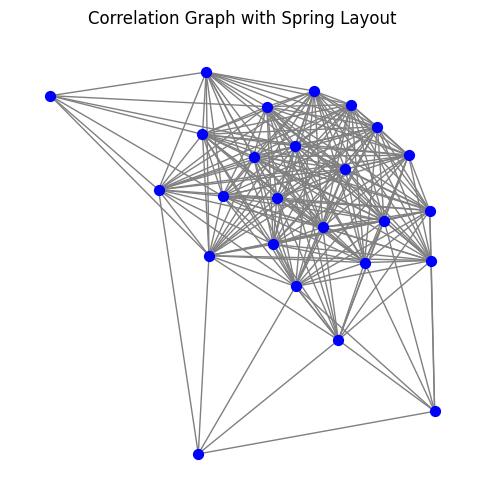

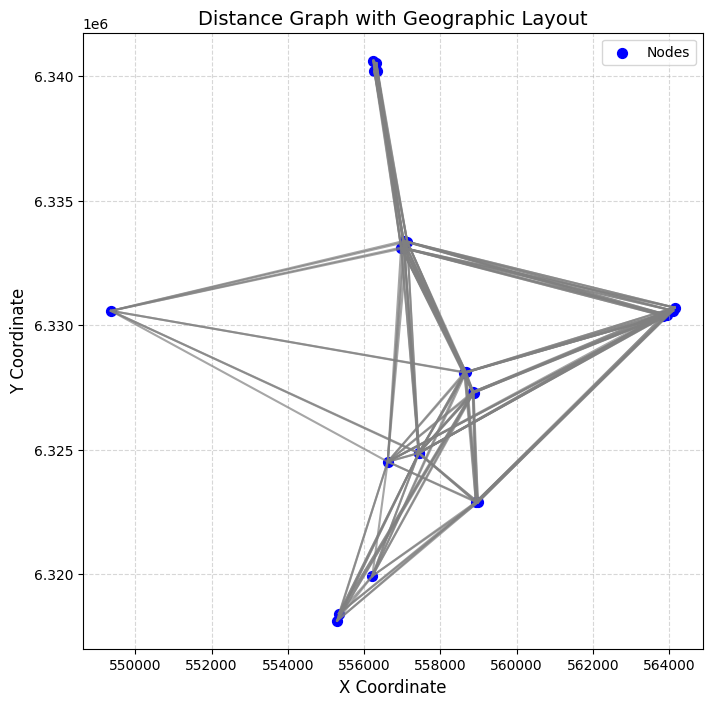

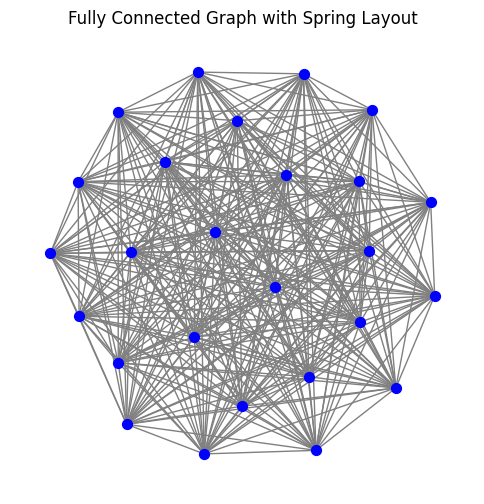

In [38]:
# Plot the Correlation graph without labels or edge attributes, use a spring layout, with a title that explain how they where plotted
plt.figure(figsize=(6, 6))
plt.title("Correlation Graph with Spring Layout")
pos = nx.spring_layout(correlation_graph_weighted)
nx.draw(correlation_graph_weighted, pos, with_labels=False, node_size=50, node_color='blue', edge_color='gray')
plt.show()

# Extract positions from the graph's node attributes
pos = {node: (data['x'], data['y']) for node, data in distance_graph_weighted.nodes(data=True)}

# Extract x and y coordinates for nodes
x_values = [coord[0] for coord in pos.values()]
y_values = [coord[1] for coord in pos.values()]

# Plot the distance graph
plt.figure(figsize=(8, 8))
plt.title("Distance Graph with Geographic Layout", fontsize=14)

plt.grid(True, linestyle='--', alpha=0.5)
plt.scatter(x_values, y_values, c='blue', s=50, label='Nodes')


for edge in distance_graph_weighted.edges():
    x_coords = [pos[edge[0]][0], pos[edge[1]][0]]
    y_coords = [pos[edge[0]][1], pos[edge[1]][1]]
    plt.plot(x_coords, y_coords, color='gray', alpha=0.7)

# Set axis labels
plt.xlabel("X Coordinate", fontsize=12)
plt.ylabel("Y Coordinate", fontsize=12)


# Show legend
plt.legend()
# Display the plot
plt.show()

# Plot the Correlation graph without labels or edge attributes, use a spring layout, with a title that explain how they where plotted
plt.figure(figsize=(6, 6))
plt.title("Fully Connected Graph with Spring Layout")
pos = nx.spring_layout(fully_connected_graph)
nx.draw(fully_connected_graph, pos, with_labels=False, node_size=50, node_color='blue', edge_color='gray')
plt.show()

Create GCN Model 

In [39]:
import torch
import numpy as np
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.model_selection import train_test_split

In [40]:
# Use the appropriate graph creation function
graph, _ = create_distance_graph(final_dataframes, weighted=True)

# Extract node attributes and edge information
x_coords = [data['x'] for _, data in graph.nodes(data=True)]
y_coords = [data['y'] for _, data in graph.nodes(data=True)]
traffic_series = [data['traffic_flow'] for _, data in graph.nodes(data=True)]  # Match traffic data field

# Convert traffic data list to a 2D numpy array
traffic_series = np.stack(traffic_series)

# Sliding window parameters
lookback = 50  # Number of time steps to look back
pred_horizon = 1  # Predict the next time step

# Create sliding window input and output tensors
def create_sliding_window_data(traffic_series, lookback, pred_horizon):
    X, y = [], []
    for node_series in traffic_series:
        for i in range(len(node_series) - lookback - pred_horizon + 1):
            X.append(node_series[i:i + lookback])  # Input: Lookback window
            y.append(node_series[i + lookback:i + lookback + pred_horizon])  # Output: Next step(s)
    return np.array(X), np.array(y)

# Generate sliding window data
X, y = create_sliding_window_data(traffic_series, lookback, pred_horizon)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float)  # Shape: [num_samples, lookback]
y = torch.tensor(y, dtype=torch.float)  # Shape: [num_samples, pred_horizon]

# Prepare graph edges with integer mapping
node_mapping = {node: idx for idx, node in enumerate(graph.nodes())}

edge_index = torch.tensor(
    [[node_mapping[edge[0]], node_mapping[edge[1]]] for edge in graph.edges],
    dtype=torch.long
).t().contiguous()

# Create PyTorch Geometric Data object
# data = Data(x=X, edge_index=edge_index, y=y.view(-1, pred_horizon))  # Include target in data

# Split the dataset into training, validation, and test sets
# First split into train + val and test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Then split train + val into train and val
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2 of the original dataset

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

# Create separate Data objects for training, validation, and test sets
train_data = Data(x=X_train, edge_index=edge_index, y=y_train.view(-1, pred_horizon))
val_data = Data(x=X_val, edge_index=edge_index, y=y_val.view(-1, pred_horizon))
test_data = Data(x=X_test, edge_index=edge_index, y=y_test.view(-1, pred_horizon))


Removed 0 self-loops and 0 duplicate edges. Choose the Largest Component: 25 nodes.
Training samples: 515985
Validation samples: 171995
Test samples: 171995


In [ ]:
# Define GNN model
class TrafficGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = self.fc(x)
        return x

# Initialize model, optimizer, and loss function
model = TrafficGNN(in_channels=lookback, hidden_channels=32, out_channels=pred_horizon)
optimizer = Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()

# Initialize lists to store training and validation losses
train_losses = []
val_losses = []

# Lists to store actual and predicted values for plotting
actual_values = []
predicted_values = []

# Training loop with validation
model.train()
for epoch in range(100_000):
    optimizer.zero_grad()
    
    # Forward pass on training data
    out = model(train_data)
    train_loss = criterion(out, train_data.y)
    
    # Backward pass
    train_loss.backward()
    optimizer.step()
    
    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_out = model(val_data)
        val_loss = criterion(val_out, val_data.y)

        # Store actual and predicted values after each epoch
        actual_values.append(val_data.y.cpu().numpy())
        predicted_values.append(val_out.cpu().numpy())
    
    model.train()  # Switch back to training mode

    # Store losses for plotting
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    # Print loss every 100 epochs
    if epoch % 1 == 0:
        print(f"Epoch {epoch}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

# Convert actual and predicted values to numpy arrays for plotting
actual_values = np.vstack(actual_values)
predicted_values = np.vstack(predicted_values)


Epoch 0, Training Loss: 6723.94873046875, Validation Loss: 6664.66796875
Epoch 1, Training Loss: 6637.54638671875, Validation Loss: 6578.82275390625
Epoch 2, Training Loss: 6552.18603515625, Validation Loss: 6494.03564453125
Epoch 3, Training Loss: 6467.8720703125, Validation Loss: 6410.31494140625
Epoch 4, Training Loss: 6384.6123046875, Validation Loss: 6327.65185546875
Epoch 5, Training Loss: 6302.3994140625, Validation Loss: 6246.04345703125
Epoch 6, Training Loss: 6221.23193359375, Validation Loss: 6165.48486328125
Epoch 7, Training Loss: 6141.1044921875, Validation Loss: 6085.95556640625
Epoch 8, Training Loss: 6062.01220703125, Validation Loss: 6007.4638671875
Epoch 9, Training Loss: 5983.95458984375, Validation Loss: 5930.0107421875
Epoch 10, Training Loss: 5906.91943359375, Validation Loss: 5853.58349609375
Epoch 11, Training Loss: 5830.89892578125, Validation Loss: 5778.16845703125
Epoch 12, Training Loss: 5755.8857421875, Validation Loss: 5703.76123046875
Epoch 13, Training 

In [ ]:
# save model
torch.save(model.state_dict(), 'model.pth')

In [44]:
# Test the model
model.eval()
with torch.no_grad():
    test_out = model(test_data)
    test_loss = criterion(test_out, test_data.y)
    print(f"Test Loss: {test_loss.item()}")

Test Loss: 117.05791473388672


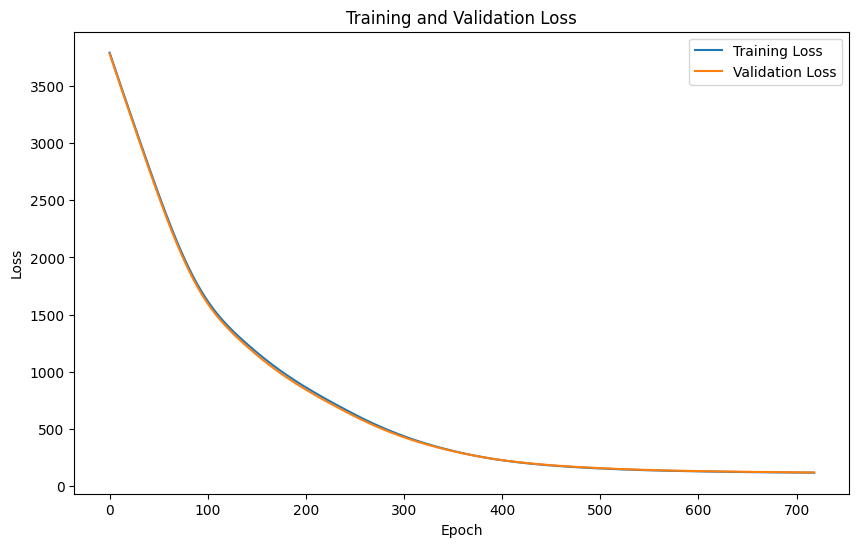

In [45]:
# Plot test and validaiton loss 
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

NameError: name 'actual' is not defined

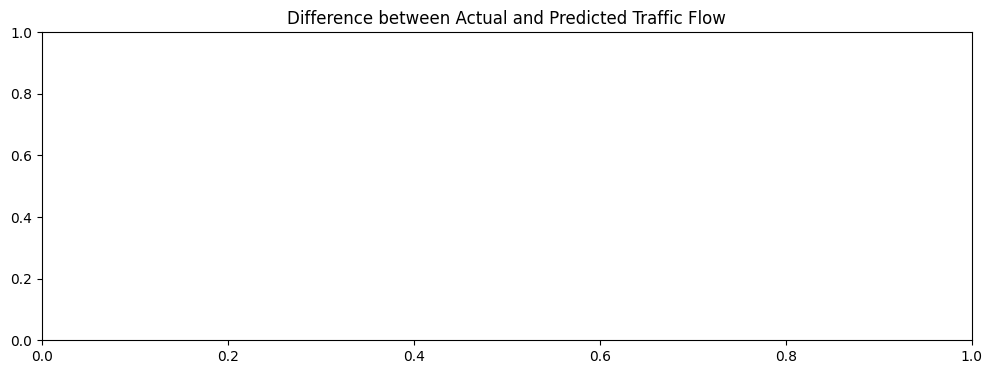

In [ ]:

#  Plot the difference between actual and predicted values
plt.figure(figsize=(12, 4))
plt.title("Difference between Actual and Predicted Traffic Flow")
plt.plot(predicted_values[0:100] - actual_values[0:100])


plt.figure(figsize=(12, 4))
plt.title("Predicted vs Actual Traffic Flow")
plt.plot(predicted_values[0:100])
plt.plot(actual_values[0:100])

# make a scatter plot of the first 100 predictions
plt.figure(figsize=(5, 5))
plt.scatter(predicted_values[:1000], actual_values[:1000], s=10)
plt.xlabel('Predicted Traffic Flow')
plt.ylabel('Actual Traffic Flow')
plt.title('Predicted vs Actual Traffic Flow')
plt.show()



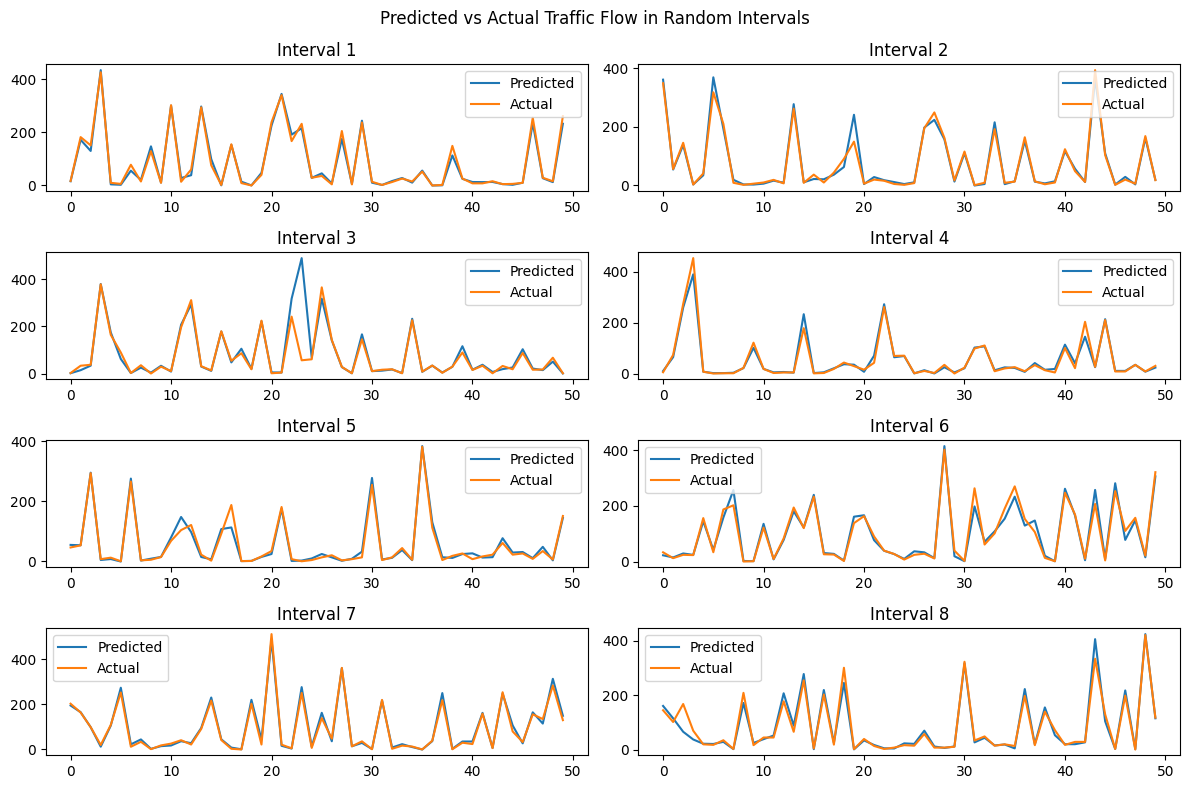

In [ ]:
# Make 4 subplots which show 4 randomly chosen intervals of 200 predictions and their actual values. 
# The x-axis should represent the time steps and the y-axis the traffic flow values.
fig, axs = plt.subplots(4, 2, figsize=(12, 8))
fig.suptitle('Predicted vs Actual Traffic Flow in Random Intervals')

for i, ax in enumerate(axs.flat):
    start = np.random.randint(0, len(predictions) - 50)
    end = start + 50

    ax.plot(predictions[start:end], label='Predicted')
    ax.plot(actual[start:end], label='Actual')
    ax.set_title(f'Interval {i+1}')
    ax.legend()

plt.tight_layout()
plt.show()
